# we are going to see how to update and check for different values for learning rate

In [22]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt

In [3]:
def forward(X, W1, b1, W2, b2):
    # relu
    Z = X.dot(W1) + b1
    Z[Z < 0] = 0

    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y, Z

In [4]:
def derivative_w1(X,Z,T,Y,W2):
    return X.T.dot( ( ( Y-T ).dot(W2.T) * ( Z*(1 - Z) ) ) )

In [5]:
def derivative_w2(Z,T,Y):
    return Z.T.dot(Y-T)

In [6]:
def derivative_b2(T,Y):
    return (Y-T).sum(axis=0)

In [43]:
def derivative_w1(X,Z,T,Y,W2):
    #return X.T.dot((Y-T).dot(W2.dot(W2)*(Z*(1-Z))))  for sigmoid
    return X.T.dot( ( ( Y-T ).dot(W2.T) * (Z > 0) ) ) # for relu

In [44]:
def derivative_b1(Z, T, Y, W2):
     #return (( Y-T ).dot(W2.T) * ( Z*(1 - Z) )).sum(axis=0) # for sigmoid
     return (( Y-T ).dot(W2.T) * (Z > 0)).sum(axis=0) # for relu

In [9]:
def y2indicator(y):
    n=len(y)
    y=y.astype(np.int32)
    k=y.max()+1
    ind=np.zeros((n,k))
    for n in range(n):
        k=y[n]
        ind[n,k]=1
    return ind

In [10]:
def cost(y_pred,y_true):
    tot=y_true*np.log(y_pred)
    return -tot.sum()

In [11]:
def predict(y_pred):
    return np.argmax(y_pred,axis=1)

In [12]:
def error_rate(y_pred,y_true):
    prediction=predict(y_pred)
    return np.mean(prediction!= y_true)

In [13]:
#this calculated the gradient of the weights
def gradw(y_true,y_pred,X):
    return X.T.dot(y_true-y_pred)

In [14]:
#this calculates the gradient of the biases
def gradb(y_true,y_pred):
    return (y_true-y_pred).sum(axis=0)

In [16]:
def get_normalized_data():
    df = pd.read_csv('C:/Users/dread-miles/Documents/Data Sets/mnist/mnist_train.csv')
    
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]

    # normalize the data
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)
    np.place(std, std == 0, 1)
    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    return Xtrain, Xtest, Ytrain, Ytest


In [55]:
from __future__ import division
def main():
    max_iter=30
    print_period=10

    x_train,x_test,y_train,y_test=get_normalized_data()
    lr=0.00004
    reg=0.01
    
    ytrain_ind=y2indicator(y_train)
    ytest_ind=y2indicator(y_test)
    n,d=x_train.shape

    batch_sz=500
    n_batches=n//batch_sz

    m=300
    k=10
    
    w1=np.random.randn(d,m)/np.sqrt(d)
    b1=np.zeros(m)
    w2=np.random.randn(m,k)/np.sqrt(m)
    b2=np.zeros(k)

    #const
    los_batch=[]
    er_batch=[]

    for i in range(max_iter):
        for j in range(n_batches):
            x_batch=x_train[j*batch_sz:(j+1)*batch_sz,]
            y_batch=ytrain_ind[j*batch_sz:(j+1)*batch_sz,]
            y_pred,z=forward(x_batch,w1,b1,w2,b2)

            #gradients after back propagation
            gw2=derivative_w2(z,y_pred,y_batch) + reg*w2
            gb2=derivative_b2(y_batch,y_pred)+ reg*b2
            gw1=derivative_w1(x_batch,z,y_batch,y_pred,w2)+reg*w1
            gb1=derivative_b1(z,y_batch,y_pred,w2) + reg*b1

            #upgrade
            w2-=lr*gw2
            b2-=lr*gb2
            w1-=lr*gw1
            b1-=lr*gb1

            #lets print every 10 epochs
            if j%print_period==0:
                #lets add the loss
                py,_=forward(x_test,w1,b1,w2,b2)
                ll=cost(py,ytest_ind)
                los_batch.append(ll)
                print("cost at iteration for constant i=%d,=%d:%0.6f" %(i,j,ll))

                err=error_rate(py,y_test)
                er_batch.append(err)
                print("error rate",err)
    
    py,_=forward(x_test,w1,b1,w2,b2)
    print("final error rate in constant:",error_rate(py,y_test))

    #RMS prop
    w1=np.random.randn(d,m)/np.sqrt(d)
    b1=np.zeros(m)
    w2=np.random.randn(m,k)/np.sqrt(m)
    b2=np.zeros(k)

    los_rms=[]
    er_rms=[]
    lr0=0.001

    cache_w2=1
    cache_b2=1
    cache_w1=1
    cache_b1=1
    decay_rate=0.999
    eps=1e-10

    for i in range(max_iter):
        for j in range(n_batches):
            x_batch=x_train[j*batch_sz:(j+1)*batch_sz,]
            y_batch=ytrain_ind[j*batch_sz:(j+1)*batch_sz,]
            y_pred,z=forward(x_batch,w1,b1,w2,b2)

            #gradients
            gw2=derivative_w2(z,y_pred,y_batch) + reg*w2
            gb2=derivative_b2(y_batch,y_pred)+ reg*b2
            gw1=derivative_w1(x_batch,z,y_batch,y_pred,w2)+reg*w1
            gb1=derivative_b1(z,y_batch,y_pred,w2) + reg*b1

            #cache
            cache_w2=decay_rate*cache_w2 + (1-decay_rate)*gw2*gw2
            cache_b2=decay_rate*cache_b2 + (1-decay_rate)*gb2*gb2
            cache_w1=decay_rate*cache_w1 + (1-decay_rate)*gw1*gw1
            cache_b1=decay_rate*cache_b1 + (1-decay_rate)*gb1*gb1

            #update weights
            w2-=lr0*gw2 /(np.sqrt(cache_w2)+eps)
            b2-=lr0*gb2 /(np.sqrt(cache_b2)+eps)
            w1-=lr0*gw1 /(np.sqrt(cache_w1)+eps)
            b1-=lr0*gb1 /(np.sqrt(cache_b1)+eps)

            if j% print_period == 0:
                py,_=forward(x_test,w1,b1,w2,b2)
                ll=cost(py,ytest_ind)
                los_rms.append(ll)
                print("cost at each iteration for RMSprop  %d %d %.6f" %(i,j,ll))

                err=error_rate(py,y_test)
                er_rms.append(err)
                print("error rate:",err)
    
    py,_=forward(x_test,w1,b1,w2,b2)
    print("the final error is in RMSprop:",error_rate(py,y_test))
    
    plt.plot(los_batch,label="const")
    plt.plot(los_rms,label="rms")
    plt.legend()
    plt.show()

cost at iteration for constant i=0,=0:2447.817850
error rate 0.918
cost at iteration for constant i=0,=10:2278.125423
error rate 0.87
cost at iteration for constant i=0,=20:3273.068237
error rate 0.911
cost at iteration for constant i=0,=30:7428.947236
error rate 0.911
cost at iteration for constant i=0,=40:10839.164396
error rate 0.911
cost at iteration for constant i=0,=50:12561.403863
error rate 0.911
cost at iteration for constant i=0,=60:12982.351200
error rate 0.911
cost at iteration for constant i=0,=70:12478.245808
error rate 0.911
cost at iteration for constant i=0,=80:11546.069031
error rate 0.911
cost at iteration for constant i=0,=90:10310.073893
error rate 0.911
cost at iteration for constant i=0,=100:8998.901039
error rate 0.911
cost at iteration for constant i=0,=110:7813.891645
error rate 0.911
cost at iteration for constant i=1,=0:6919.793594
error rate 0.909
cost at iteration for constant i=1,=10:6011.944881
error rate 0.899
cost at iteration for constant i=1,=20:5259

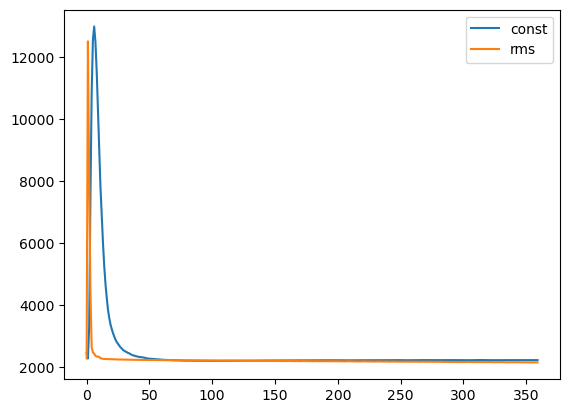

In [56]:
main()

In [ ]:
#if __name__== '__main__':
#    main()